In [1]:
#import necessary packages
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
import seaborn as sns
import datetime
import warnings 
warnings.simplefilter('ignore') 

#load map packages
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from calendar import month_abbr

In [13]:
ddir = '~/shared/users/mgarciareyes/saildrone_data/'  #data 2
fn = 'saildrone_west_coast_survey_2019_sd1047_JPLv5.0_8dy_20210613norep_20210613_20211116.nc'

In [4]:
#open .nc file with Saildrone Data
sail = xr.open_dataset(ddir+fn) 
sail.close()

#copy data for calculations versus graphing
sail_raw = sail.copy()

<xarray.Dataset>
Dimensions:                       (time: 5)
Coordinates:
    trajectory                    float32 ...
  * time                          (time) datetime64[ns] 2019-07-23T07:12:55.8...
    ob                            (time) int64 ...
Data variables: (12/41)
    lat                           (time) float64 ...
    lon                           (time) float64 ...
    SOG_MEAN                      (time) float64 ...
    COG_MEAN                      (time) float64 ...
    HDG_MEAN                      (time) float64 ...
    ROLL_MEAN                     (time) float64 ...
    ...                            ...
    sat_lon                       (time) float64 ...
    dist_land                     (time) float64 ...
    analysed_sst                  (time) float64 ...
    analysis_error                (time) float64 ...
    mask                          (time) float64 ...
    sea_ice_fraction              (time) float64 ...
Attributes: (12/45)
    area:                      Pacific Ocean
    cdm_data_type:             Trajectory
    cdm_trajectory_variables:  trajectory
    Conventions:               CF-1.6, ACDD-1.3, COARDS
    creator_email:             support@saildrone.com
    creator_name:              Saildrone
    ...                        ...
    time_coverage_end:         2019-09-03T19:57:00Z
    time_coverage_resolution:  PT1M
    time_coverage_start:       2019-06-20T02:00:00Z
    title:                     Saildrone West Coast Survey 2019
    Westernmost_Easting:       -124.9878272
    vehicle_id:                sd1047

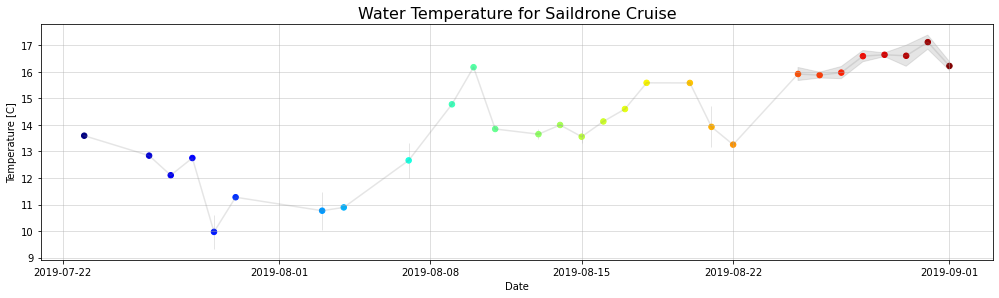

In [14]:
#resample the data by Day
resampled_temp = sail_raw.resample(time="D", skipna = True).mean()

#set figure size
plt.figure(figsize = (14,4))

#create lineplot 
sns.lineplot(x = sail_raw['time'].dt.date, y = sail_raw['TEMP_CTD_MEAN'], color = 'grey', ci = 'sd', alpha=0.2)
plt.scatter(resampled_temp['time'].dt.date, resampled_temp['TEMP_CTD_MEAN'], 30, [*range(len(resampled_temp['TEMP_CTD_MEAN']))], 'o', cmap='jet')
plt.tight_layout()

#set labels
plt.title('Water Temperature for Saildrone Cruise', fontdict = {'fontsize' : 16})
plt.xlabel("Date")
plt.ylabel("Temperature [C]")

#reformat x-axis ticks
plt.grid(zorder=0, alpha=0.5)
plt.show()

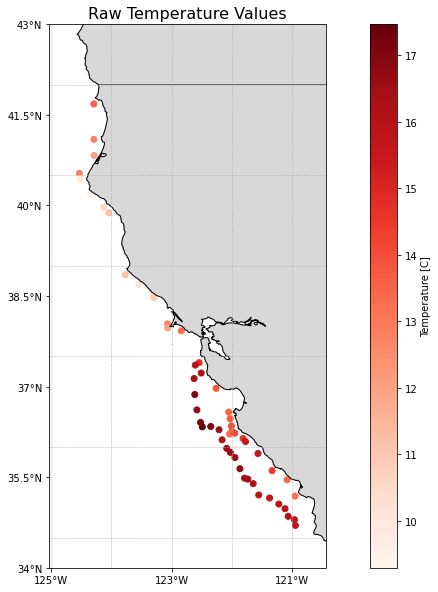

In [12]:
#define latitude and longitude boundaries
latr = [min(sail_raw['lat']), max(sail_raw['lat'])] 
lonr = [max(sail_raw['lon']), min(sail_raw['lon'])] 

# Select a region of our data, giving it a margin
margin = 0.5 
region = np.array([[latr[0]-margin,latr[1]+margin],[lonr[0]+margin,lonr[1]-margin]]) 

#add state outlines
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')

# Create and set the figure context
fig = plt.figure(figsize=(16,10), dpi = 72) 
ax = plt.axes(projection=ccrs.PlateCarree()) 
ax.coastlines(resolution='10m',linewidth=1,color='black') 
ax.add_feature(cfeature.LAND, color='grey', alpha=0.3)
ax.add_feature(states_provinces, linewidth = 0.5)
ax.add_feature(cfeature.BORDERS)
ax.set_extent([region[1,0],region[1,1],region[0,0],region[0,1]],crs=ccrs.PlateCarree()) 
ax.set_xticks(np.round([*np.arange(region[1,1],region[1,0]+1,2)][::-1],0), crs=ccrs.PlateCarree()) 
ax.set_yticks(np.round([*np.arange(np.floor(region[0,0]),region[0,1]+1,1.5)],1), crs=ccrs.PlateCarree()) 
ax.xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label=True))
ax.yaxis.set_major_formatter(LatitudeFormatter())
ax.gridlines(linestyle = '--', linewidth = 0.5)

# Plot track data, color by temperature
sc = plt.scatter(data = sail_raw, x = 'lon', y = 'lat', c = 'TEMP_CTD_MEAN')
clb = fig.colorbar(sc, label = "Temperature [C]")
plt.set_cmap('Reds')
plt.title('Raw Temperature Values', fontdict = {'fontsize' : 16})
plt.show()